In [3]:
!pip install tensorflow

!pip install opencv-python opencv-python-headless opencv-contrib-python


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 644.9/644.9 MB 551.2 kB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.5/57.5 kB 3.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.5/24.5 MB 68.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 89.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.1/5.1 MB 75.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.6/6.6 MB 88.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.5/224.5 kB 14.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.5/72.5 kB 4.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.0/63.0 MB 19.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.0/50.0 MB 25.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 69.1/69.1 MB 17.1 MB/s eta 0:00:00


In [4]:
import os
import cv2
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import kagglehub
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay


In [5]:
path = kagglehub.dataset_download("odins0n/ucf-crime-dataset")
print("Path to dataset files:", path)

100%|██████████| 11.0G/11.0G [01:07<00:00, 175MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/odins0n/ucf-crime-dataset/versions/1


In [6]:
train_dir = os.path.join(path, "Train")
test_dir = os.path.join(path, "Test")

classes = ["Fighting", "Robbery", "Shooting", "Stealing", "NormalVideos"]
num_classes = len(classes)

In [7]:
import os
import cv2
import numpy as np
from sklearn.model_selection import train_test_split

img_width, img_height = 100, 100

def balance_dataset(directory, classes, max_samples_per_class=7140):
    X, y = [], []
    class_to_label = {class_name: i for i, class_name in enumerate(classes)}

    for class_name in classes:
        class_dir = os.path.join(directory, class_name)
        if not os.path.exists(class_dir):
            continue

        image_files = os.listdir(class_dir)[:max_samples_per_class]

        for image_file in image_files:
            image_path = os.path.join(class_dir, image_file)
            image = cv2.imread(image_path)
            if image is not None:
                image = cv2.resize(image, (img_width, img_height))
                image = image / 255.0
                X.append(image)
                y.append(class_to_label[class_name])

    return np.array(X), np.array(y)

X_train, y_train = balance_dataset(train_dir, classes)
X_test, y_test = balance_dataset(test_dir, classes)

X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size=0.2, stratify=y_train, random_state=42)


In [ ]:
datagen = ImageDataGenerator(
    rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest'
)

datagen.fit(X_train)

In [ ]:
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(img_width, img_height, 3)),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(256, activation='relu'),
    Dropout(0.5),
    Dense(num_classes, activation='softmax')
])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [ ]:
optimizer = Adam(learning_rate=0.001)
model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True, verbose=1)
checkpoint = ModelCheckpoint('crime_classification_model.keras', save_best_only=True, monitor='val_accuracy', mode='max')

history = model.fit(
    datagen.flow(X_train, y_train, batch_size=16),
    epochs=30,
    validation_data=(X_test, y_test),
    callbacks=[early_stop, checkpoint]
)

Epoch 1/30


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


1785/1785 ━━━━━━━━━━━━━━━━━━━━ 535s 299ms/step - accuracy: 0.4507 - loss: 1.2973 - val_accuracy: 0.7821 - val_loss: 0.5964
Epoch 2/30
1785/1785 ━━━━━━━━━━━━━━━━━━━━ 537s 301ms/step - accuracy: 0.7534 - loss: 0.6743 - val_accuracy: 0.9183 - val_loss: 0.2752
Epoch 3/30
1785/1785 ━━━━━━━━━━━━━━━━━━━━ 518s 290ms/step - accuracy: 0.8451 - loss: 0.4359 - val_accuracy: 0.9546 - val_loss: 0.1583
Epoch 4/30
1785/1785 ━━━━━━━━━━━━━━━━━━━━ 522s 293ms/step - accuracy: 0.8918 - loss: 0.3204 - val_accuracy: 0.9605 - val_loss: 0.1258
Epoch 5/30
1785/1785 ━━━━━━━━━━━━━━━━━━━━ 517s 289ms/step - accuracy: 0.9067 - loss: 0.2777 - val_accuracy: 0.9706 - val_loss: 0.0951
Epoch 6/30
1785/1785 ━━━━━━━━━━━━━━━━━━━━ 514s 288ms/step - accuracy: 0.9267 - loss: 0.2208 - val_accuracy: 0.9724 - val_loss: 0.0921
Epoch 7/30
1785/1785 ━━━━━━━━━━━━━━━━━━━━ 523s 293ms/step - accuracy: 0.9286 - loss: 0.2222 - val_accuracy: 0.9737 - val_loss: 0.0859
Epoch 8/30
1785/1785 ━━━━━━━━━━━━━━━━━━━━ 533s 299ms/step - accuracy: 0.9

In [ ]:
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print(f"Train Accuracy: {history.history['accuracy'][-1] * 100:.2f}%")
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")

224/224 ━━━━━━━━━━━━━━━━━━━━ 25s 109ms/step - accuracy: 0.9893 - loss: 0.0403
Train Accuracy: 96.19%
Test Accuracy: 98.81%


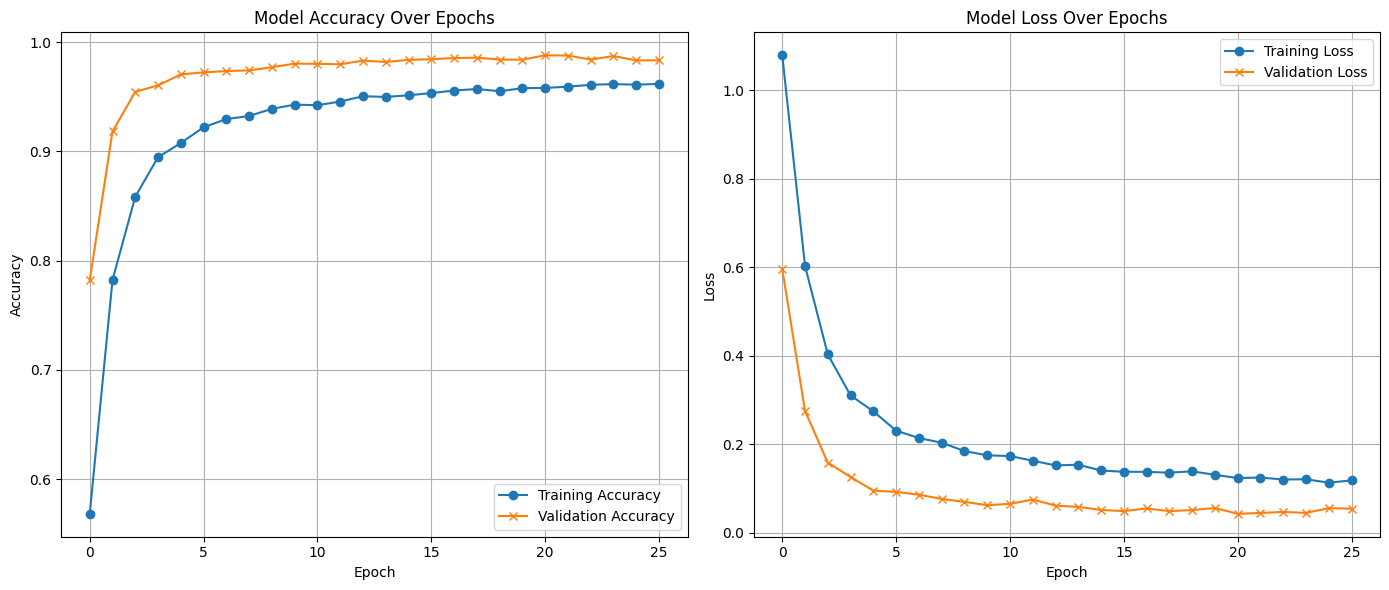

224/224 ━━━━━━━━━━━━━━━━━━━━ 25s 113ms/step


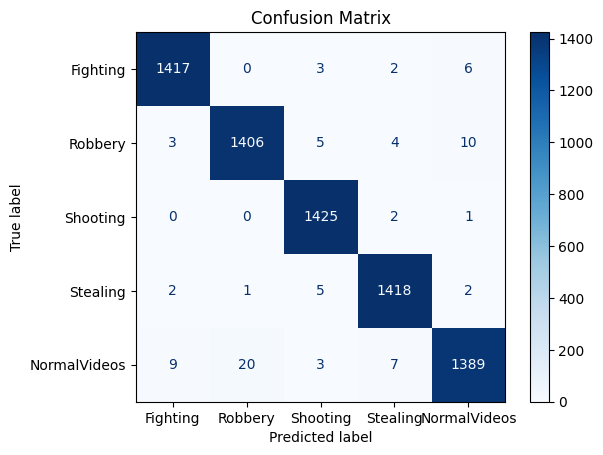

In [ ]:
plt.figure(figsize=(14, 6))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy', marker='o')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy', marker='x')
plt.title('Model Accuracy Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss', marker='o')
plt.plot(history.history['val_loss'], label='Validation Loss', marker='x')
plt.title('Model Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

y_pred = np.argmax(model.predict(X_test), axis=1)
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classes)
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()

العلامة المتوقعة للصورة 10: Robbery
العلامة الحقيقية للصورة 10: Robbery


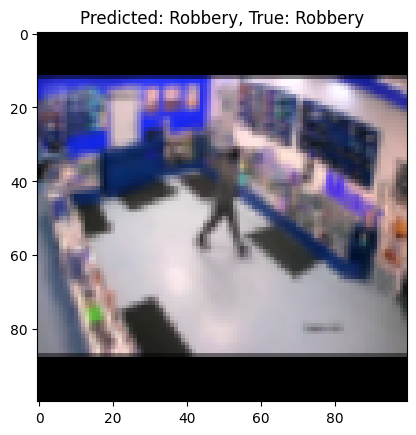

In [ ]:
image_index = 10 
predicted_label = classes[y_pred[image_index]] 
true_label = classes[y_test[image_index]]

print(f"العلامة المتوقعة للصورة {image_index}: {predicted_label}")
print(f"العلامة الحقيقية للصورة {image_index}: {true_label}")

plt.imshow(X_test[image_index]) 
plt.title(f"Predicted: {predicted_label}, True: {true_label}")
plt.show()


### Reduce DropOut

In [8]:
datagen = ImageDataGenerator(
    rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest'
)

datagen.fit(X_train)

In [9]:
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(img_width, img_height, 3)),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(256, activation='relu'),
    Dropout(0.3),
    Dense(num_classes, activation='softmax')
])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [10]:
optimizer = Adam(learning_rate=0.001)
model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True, verbose=1)
checkpoint = ModelCheckpoint('crime_classification_model.keras', save_best_only=True, monitor='val_accuracy', mode='max')

history = model.fit(
    datagen.flow(X_train, y_train, batch_size=16),
    epochs=30,
    validation_data=(X_test, y_test),
    callbacks=[early_stop, checkpoint]
)

Epoch 1/30


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


1785/1785 ━━━━━━━━━━━━━━━━━━━━ 94s 52ms/step - accuracy: 0.4820 - loss: 1.2355 - val_accuracy: 0.8667 - val_loss: 0.4013
Epoch 2/30
1785/1785 ━━━━━━━━━━━━━━━━━━━━ 91s 51ms/step - accuracy: 0.8125 - loss: 0.5292 - val_accuracy: 0.9357 - val_loss: 0.2045
Epoch 3/30
1785/1785 ━━━━━━━━━━━━━━━━━━━━ 91s 51ms/step - accuracy: 0.8909 - loss: 0.3147 - val_accuracy: 0.9674 - val_loss: 0.1083
Epoch 4/30
1785/1785 ━━━━━━━━━━━━━━━━━━━━ 91s 51ms/step - accuracy: 0.9188 - loss: 0.2398 - val_accuracy: 0.9653 - val_loss: 0.1039
Epoch 5/30
1785/1785 ━━━━━━━━━━━━━━━━━━━━ 91s 51ms/step - accuracy: 0.9326 - loss: 0.1997 - val_accuracy: 0.9776 - val_loss: 0.0714
Epoch 6/30
1785/1785 ━━━━━━━━━━━━━━━━━━━━ 91s 51ms/step - accuracy: 0.9405 - loss: 0.1757 - val_accuracy: 0.9790 - val_loss: 0.0633
Epoch 7/30
1785/1785 ━━━━━━━━━━━━━━━━━━━━ 90s 50ms/step - accuracy: 0.9519 - loss: 0.1478 - val_accuracy: 0.9810 - val_loss: 0.0578
Epoch 8/30
1785/1785 ━━━━━━━━━━━━━━━━━━━━ 90s 51ms/step - accuracy: 0.9537 - loss: 0.13

In [11]:

test_loss, test_accuracy = model.evaluate(X_test, y_test)
print(f"Train Accuracy: {history.history['accuracy'][-1] * 100:.2f}%")
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")

224/224 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - accuracy: 0.9877 - loss: 0.0372
Train Accuracy: 97.98%
Test Accuracy: 98.95%


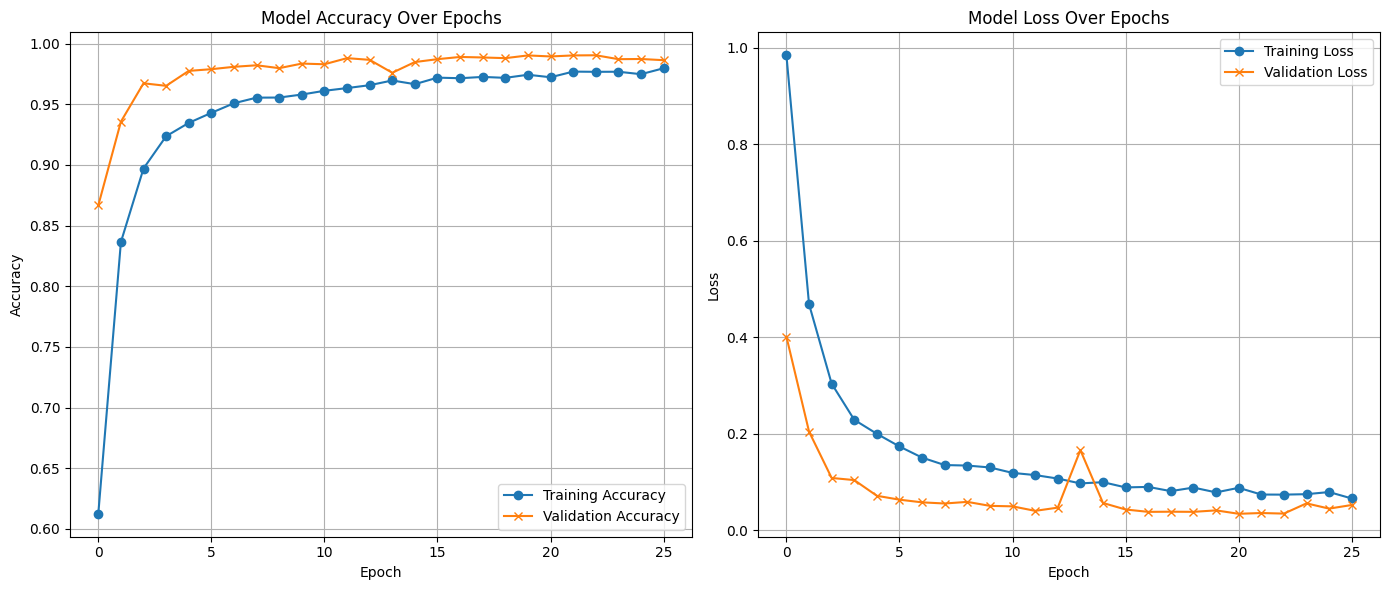

224/224 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step


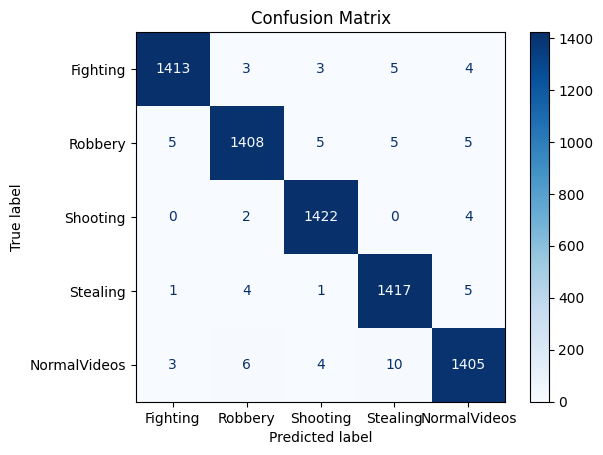

In [12]:
plt.figure(figsize=(14, 6))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy', marker='o')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy', marker='x')
plt.title('Model Accuracy Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss', marker='o')
plt.plot(history.history['val_loss'], label='Validation Loss', marker='x')
plt.title('Model Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

y_pred = np.argmax(model.predict(X_test), axis=1)
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classes)
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()

224/224 ━━━━━━━━━━━━━━━━━━━━ 4s 17ms/step


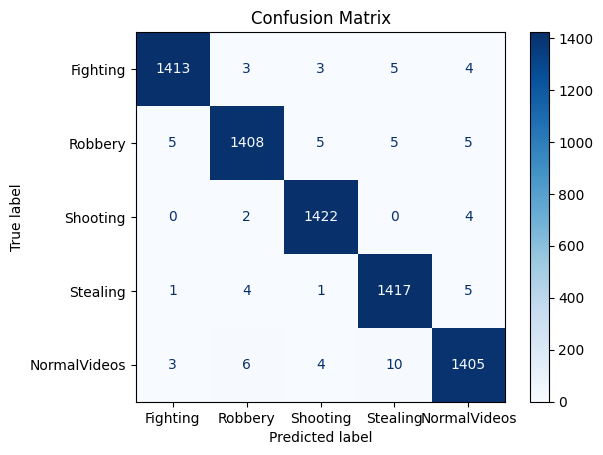

العلامة المتوقعة للصورة 10: Robbery
العلامة الحقيقية للصورة 10: Robbery


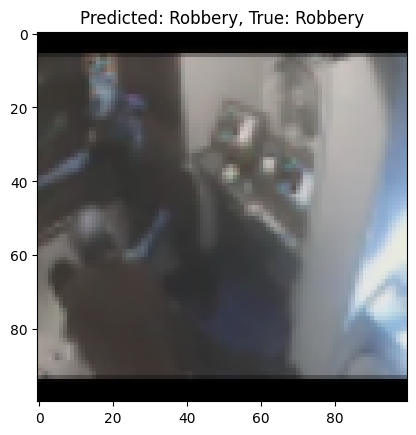

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from tensorflow.keras.models import load_model


y_pred = np.argmax(model.predict(X_test), axis=1)

cm = confusion_matrix(y_test, y_pred)

classes = ["Fighting", "Robbery", "Shooting", "Stealing", "NormalVideos"]

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classes)
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()

image_index = 10  
predicted_label = classes[y_pred[image_index]] 
true_label = classes[y_test[image_index]]

print(f"العلامة المتوقعة للصورة {image_index}: {predicted_label}")
print(f"العلامة الحقيقية للصورة {image_index}: {true_label}")

plt.imshow(X_test[image_index])  
plt.title(f"Predicted: {predicted_label}, True: {true_label}")
plt.show()


In [19]:
model.save('cnn2_model.keras')